## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [ ]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [ ]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

In [44]:
import openlane

print(openlane.__version__)

2.3.10


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [53]:
%%writefile spm.v
module spm #(
    parameter DATA_WIDTH = 8,
    parameter DEPTH = 16
)(
    input clk,
    input rst,
    input wr_en,
    input rd_en,
    input [DATA_WIDTH-1:0] din,
    output reg [DATA_WIDTH-1:0] dout,
    output reg full,
    output reg empty
);

    reg [DATA_WIDTH-1:0] mem [0:DEPTH-1];
    reg [$clog2(DEPTH):0] wr_ptr, rd_ptr, count;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            wr_ptr <= 0;
            rd_ptr <= 0;
            count  <= 0;
            full   <= 0;
            empty  <= 1;
        end else begin
            // Write operation
            if (wr_en && !full) begin
                mem[wr_ptr] <= din;
                wr_ptr <= wr_ptr + 1;
                count <= count + 1;
            end

            // Read operation
            if (rd_en && !empty) begin
                dout <= mem[rd_ptr];
                rd_ptr <= rd_ptr + 1;
                count <= count - 1;
            end

            // Update flags
            full  <= (count == DEPTH);
            empty <= (count == 0);
        end
    end
endmodule

Overwriting spm.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [54]:
from openlane.config import Config

Config.interactive(
    "spm",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: spm
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.3.10
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [55]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [56]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [57]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./spm.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[21:45:29] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=734131;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=143122;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:45:29] VERBOSE  Logging subprocess to ]8;id=557430;file:///content/openlane_run/9-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=779540;file:///content/openlane_run/9-yosys-synthesis/yosys-synthesis.log\9]8;;\]8;id=557430;file:///content/openlane_run/9-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…          ]8;id=282062;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=862897;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/nix/store/306znyj77fv49kwnkpxmb0j2znqpa8bj-bash-5.2p26/bin/bash: warning: setlocale: LC_ALL: cannot change locale 
(en_US.UTF-8)

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./spm.v

Parsing SystemVerilog input from `./spm.v' to AST representation.

Generating RTLIL representation for module `\spm'.

Warning: Replacing memory \mem with list of registers. See ./spm.v:28

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \spm

3.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

Renaming module spm to spm.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/9-yosys-synthesis/hierarchy.dot'.

Dumping module spm to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \spm

6.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Removed 1 dead cases from process $proc$./spm.v:18$3 in module spm.

Marked 5 switch rules as full_case in process $proc$./spm.v:18$3 in module spm.

Removed a total of 1 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 2 redundant assignments.

Promoted 4 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst in `\spm.$proc$./spm.v:18$3'.

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

<suppressed ~4 debug messages>

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\spm.$proc$./spm.v:18$3'.

1/31: $3$mem2reg_rd$\mem$./spm.v:35$2_DATA[7:0]$22

2/31: $2$mem2reg_rd$\mem$./spm.v:35$2_DATA[7:0]$21

3/31: $2$mem2reg_rd$\mem$./spm.v:35$2_ADDR[3:0]$20

4/31: $2$mem2reg_wr$\mem$./spm.v:28$1_ADDR[3:0]$14

5/31: $2$mem2reg_wr$\mem$./spm.v:28$1_DATA[7:0]$15

6/31: $0\empty[0:0]

7/31: $0\full[0:0]

8/31: $1$mem2reg_rd$\mem$./spm.v:35$2_DATA[7:0]$11

9/31: $1$mem2reg_rd$\mem$./spm.v:35$2_ADDR[3:0]$10

10/31: $1$mem2reg_wr$\mem$./spm.v:28$1_DATA[7:0]$9

11/31: $1$mem2reg_wr$\mem$./spm.v:28$1_ADDR[3:0]$8

12/31: $0\mem[15][7:0]

13/31: $0\mem[14][7:0]

14/31: $0\mem[13][7:0]

15/31: $0\mem[12][7:0]

16/31: $0\mem[11][7:0]

17/31: $0\mem[10][7:0]

18/31: $0\mem[9][7:0]

19/31: $0\mem[8][7:0]

20/31: $0\mem[7][7:0]

21/31: $0\mem[6][7:0]

22/31: $0\mem[5][7:0]

23/31: $0\mem[4][7:0]

24/31: $0\mem[3][7:0]

25/31: $0\mem[2][7:0]

26/31: $0\mem[1][7:0]

27/31: $0\mem[0][7:0]

28/31: $0\count[4:0]

29/31: $0\rd_ptr[4:0]

30/31: $0\wr_ptr[4:0]

31/31: $0\dout[7:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

15. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\spm.\dout' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$276' with positive edge clock.

Creating register for signal `\spm.\full' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$277' with positive edge clock and positive level reset.

Creating register for signal `\spm.\empty' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$278' with positive edge clock and positive level reset.

Creating register for signal `\spm.\wr_ptr' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$279' with positive edge clock and positive level reset.

Creating register for signal `\spm.\rd_ptr' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$280' with positive edge clock and positive level reset.

Creating register for signal `\spm.\count' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$281' with positive edge clock and positive level reset.

Creating register for signal `\spm.\mem[0]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$284' with positive edge clock.

Creating register for signal `\spm.\mem[1]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$287' with positive edge clock.

Creating register for signal `\spm.\mem[2]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$290' with positive edge clock.

Creating register for signal `\spm.\mem[3]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$293' with positive edge clock.

Creating register for signal `\spm.\mem[4]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$296' with positive edge clock.

Creating register for signal `\spm.\mem[5]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$299' with positive edge clock.

Creating register for signal `\spm.\mem[6]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$302' with positive edge clock.

Creating register for signal `\spm.\mem[7]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$305' with positive edge clock.

Creating register for signal `\spm.\mem[8]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$308' with positive edge clock.

Creating register for signal `\spm.\mem[9]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$311' with positive edge clock.

Creating register for signal `\spm.\mem[10]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$314' with positive edge clock.

Creating register for signal `\spm.\mem[11]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$317' with positive edge clock.

Creating register for signal `\spm.\mem[12]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$320' with positive edge clock.

Creating register for signal `\spm.\mem[13]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$323' with positive edge clock.

Creating register for signal `\spm.\mem[14]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$326' with positive edge clock.

Creating register for signal `\spm.\mem[15]' using process `\spm.$proc$./spm.v:18$3'.

created $dff cell `$procdff$329' with positive edge clock.

Creating register for signal `\spm.$mem2reg_wr$\mem$./spm.v:28$1_ADDR' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$330' with positive edge clock and positive level reset.

Creating register for signal `\spm.$mem2reg_wr$\mem$./spm.v:28$1_DATA' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$331' with positive edge clock and positive level reset.

Creating register for signal `\spm.$mem2reg_rd$\mem$./spm.v:35$2_ADDR' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$332' with positive edge clock and positive level reset.

Creating register for signal `\spm.$mem2reg_rd$\mem$./spm.v:35$2_DATA' using process `\spm.$proc$./spm.v:18$3'.

created $adff cell `$procdff$333' with positive edge clock and positive level reset.

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Found and cleaned up 4 empty switches in `\spm.$proc$./spm.v:18$3'.

Removing empty process `spm.$proc$./spm.v:18$3'.

Cleaned up 4 empty switches.

18. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~3 debug messages>

20. Executing FLATTEN pass (flatten design).

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 8 unused cells and 69 unused wires.

<suppressed ~9 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

dead port 2/2 on $mux $procmux$45.

Removed 1 multiplexer ports.

<suppressed ~20 debug messages>

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 1 unused wires.

<suppressed ~1 debug messages>

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23.9. Rerunning OPT passes. (Maybe there is more to do..)

23.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~20 debug messages>

23.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

23.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

23.13. Executing OPT_DFF pass (perform DFF optimizations).

23.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

23.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23.16. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~20 debug messages>

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

Adding EN signal on $procdff$329 ($dff) from module spm (D = \din, Q = \mem[15]).

Adding EN signal on $procdff$326 ($dff) from module spm (D = \din, Q = \mem[14]).

Adding EN signal on $procdff$323 ($dff) from module spm (D = \din, Q = \mem[13]).

Adding EN signal on $procdff$320 ($dff) from module spm (D = \din, Q = \mem[12]).

Adding EN signal on $procdff$317 ($dff) from module spm (D = \din, Q = \mem[11]).

Adding EN signal on $procdff$314 ($dff) from module spm (D = \din, Q = \mem[10]).

Adding EN signal on $procdff$311 ($dff) from module spm (D = \din, Q = \mem[9]).

Adding EN signal on $procdff$308 ($dff) from module spm (D = \din, Q = \mem[8]).

Adding EN signal on $procdff$305 ($dff) from module spm (D = \din, Q = \mem[7]).

Adding EN signal on $procdff$302 ($dff) from module spm (D = \din, Q = \mem[6]).

Adding EN signal on $procdff$299 ($dff) from module spm (D = \din, Q = \mem[5]).

Adding EN signal on $procdff$296 ($dff) from module spm (D = \din, Q = \mem[4]).

Adding EN signal on $procdff$293 ($dff) from module spm (D = \din, Q = \mem[3]).

Adding EN signal on $procdff$290 ($dff) from module spm (D = \din, Q = \mem[2]).

Adding EN signal on $procdff$287 ($dff) from module spm (D = \din, Q = \mem[1]).

Adding EN signal on $procdff$284 ($dff) from module spm (D = \din, Q = \mem[0]).

Adding EN signal on $procdff$281 ($adff) from module spm (D = $0\count[4:0], Q = \count).

Adding EN signal on $procdff$280 ($adff) from module spm (D = $add$./spm.v:36$23_Y [4:0], Q = \rd_ptr).

Adding EN signal on $procdff$279 ($adff) from module spm (D = $add$./spm.v:29$16_Y [4:0], Q = \wr_ptr).

Adding EN signal on $procdff$276 ($dff) from module spm (D = $3$mem2reg_rd$\mem$./spm.v:35$2_DATA[7:0]$22, Q =     
\dout).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 52 unused cells and 52 unused wires.

<suppressed ~53 debug messages>

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~1 debug messages>

25.9. Rerunning OPT passes. (Maybe there is more to do..)

25.10. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

25.11. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

25.12. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

<suppressed ~48 debug messages>

Removed a total of 16 cells.

25.13. Executing OPT_DFF pass (perform DFF optimizations).

25.14. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 16 unused wires.

<suppressed ~1 debug messages>

25.15. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25.16. Rerunning OPT passes. (Maybe there is more to do..)

25.17. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

25.18. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

25.19. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

25.20. Executing OPT_DFF pass (perform DFF optimizations).

25.21. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

25.22. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25.23. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

Removed top 31 bits (of 32) from port B of cell spm.$add$./spm.v:29$16 ($add).

Removed top 27 bits (of 32) from port Y of cell spm.$add$./spm.v:29$16 ($add).

Removed top 31 bits (of 32) from port B of cell spm.$add$./spm.v:30$17 ($add).

Removed top 27 bits (of 32) from port Y of cell spm.$add$./spm.v:30$17 ($add).

Removed top 31 bits (of 32) from port B of cell spm.$add$./spm.v:36$23 ($add).

Removed top 27 bits (of 32) from port Y of cell spm.$add$./spm.v:36$23 ($add).

Removed top 31 bits (of 32) from port B of cell spm.$sub$./spm.v:37$24 ($sub).

Removed top 27 bits (of 32) from port Y of cell spm.$sub$./spm.v:37$24 ($sub).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$37_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$38_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$39_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$40_CMP0 ($eq).

Removed top 2 bits (of 4) from port B of cell spm.$procmux$41_CMP0 ($eq).

Removed top 2 bits (of 4) from port B of cell spm.$procmux$42_CMP0 ($eq).

Removed top 3 bits (of 4) from port B of cell spm.$procmux$43_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$137_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$151_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$166_CMP0 ($eq).

Removed top 1 bits (of 4) from port B of cell spm.$procmux$182_CMP0 ($eq).

Removed top 2 bits (of 4) from port B of cell spm.$procmux$199_CMP0 ($eq).

Removed top 2 bits (of 4) from port B of cell spm.$procmux$217_CMP0 ($eq).

Removed top 3 bits (of 4) from port B of cell spm.$procmux$236_CMP0 ($eq).

Removed top 27 bits (of 32) from wire spm.$add$./spm.v:29$16_Y.

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 1 unused wires.

<suppressed ~1 debug messages>

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module spm:

creating $macc model for $add$./spm.v:29$16 ($add).

creating $macc model for $add$./spm.v:30$17 ($add).

creating $macc model for $add$./spm.v:36$23 ($add).

creating $macc model for $sub$./spm.v:37$24 ($sub).

creating $alu model for $macc $sub$./spm.v:37$24.

creating $alu model for $macc $add$./spm.v:36$23.

creating $alu model for $macc $add$./spm.v:30$17.

creating $alu model for $macc $add$./spm.v:29$16.

creating $alu cell for $add$./spm.v:29$16: $auto$alumacc.cc:485:replace_alu$425

creating $alu cell for $add$./spm.v:30$17: $auto$alumacc.cc:485:replace_alu$428

creating $alu cell for $add$./spm.v:36$23: $auto$alumacc.cc:485:replace_alu$431

creating $alu cell for $sub$./spm.v:37$24: $auto$alumacc.cc:485:replace_alu$434

created 4 $alu and 0 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

31.9. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~2 debug messages>

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 1 unused cells and 2 unused wires.

<suppressed ~2 debug messages>

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.6. Executing OPT_SHARE pass.

Found cells that share an operand and can be merged by moving the $mux $procmux$263 in front of them:

$auto$alumacc.cc:485:replace_alu$434

$auto$alumacc.cc:485:replace_alu$428

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 6 unused wires.

<suppressed ~1 debug messages>

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~2 debug messages>

36.10. Rerunning OPT passes. (Maybe there is more to do..)

36.11. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~2 debug messages>

36.12. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Consolidated identical input bits for $mux cell $auto$opt_share.cc:244:merge_operators$440:

Old ports: A=5'11111, B=5'00001, Y=$auto$rtlil.cc:2573:Mux$441

New ports: A=1'1, B=1'0, Y=$auto$rtlil.cc:2573:Mux$441 [1]

New connections: { $auto$rtlil.cc:2573:Mux$441 [4:2] $auto$rtlil.cc:2573:Mux$441 [0] } = {                         
$auto$rtlil.cc:2573:Mux$441 [1] $auto$rtlil.cc:2573:Mux$441 [1] $auto$rtlil.cc:2573:Mux$441 [1] 1'1 }

Optimizing cells in module \spm.

Performed a total of 1 changes.

36.13. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.14. Executing OPT_SHARE pass.

36.15. Executing OPT_DFF pass (perform DFF optimizations).

36.16. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 2 unused wires.

<suppressed ~1 debug messages>

36.17. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~1 debug messages>

36.18. Rerunning OPT passes. (Maybe there is more to do..)

36.19. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

Evaluating internal representation of mux trees.

Analyzing evaluation results.

Removed 0 multiplexer ports.

<suppressed ~1 debug messages>

36.20. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

36.21. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.22. Executing OPT_SHARE pass.

36.23. Executing OPT_DFF pass (perform DFF optimizations).

36.24. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

36.25. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

36.26. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $reduce_and.

Using extmapper simplemap for cells of type $reduce_bool.

Using extmapper simplemap for cells of type $logic_not.

Using extmapper simplemap for cells of type $logic_and.

Using template $paramod$672a140277c71df8314410f22acc08d55222c3c7\_90_alu for cells of type $alu.

Using template $paramod$b18e16801adf491a64caa0542270798e5d4ac6b6\_90_alu for cells of type $alu.

Using extmapper simplemap for cells of type $eq.

Using extmapper simplemap for cells of type $dffe.

Using template $paramod$75a16668b548c3bac59647e2f0c7dad55b2b94b9\_90_pmux for cells of type $pmux.

Using extmapper simplemap for cells of type $not.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $adffe.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $and.

Using template $paramod\_90_lcu\WIDTH=32'00000000000000000000000000000101 for cells of type $lcu.

Using extmapper simplemap for cells of type $pos.

Using extmapper simplemap for cells of type $mux.

Using extmapper simplemap for cells of type $reduce_or.

Using extmapper simplemap for cells of type $or.

No more expansions possible.

<suppressed ~405 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

<suppressed ~191 debug messages>

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

<suppressed ~345 debug messages>

Removed a total of 115 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 16 unused cells and 313 unused wires.

<suppressed ~17 debug messages>

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\spm' to `<abc-temp-dir>/input.blif'..

Extracted 418 gates and 564 wires to a netlist network with 146 inputs and 43 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:               AND cells:        1

ABC RESULTS:               MUX cells:        8

ABC RESULTS:             ORNOT cells:       10

ABC RESULTS:               NOT cells:        9

ABC RESULTS:               NOR cells:        1

ABC RESULTS:                OR cells:      171

ABC RESULTS:              NAND cells:       15

ABC RESULTS:              XNOR cells:        3

ABC RESULTS:            ANDNOT cells:      152

ABC RESULTS:               XOR cells:        9

ABC RESULTS:        internal signals:      375

ABC RESULTS:           input signals:      146

ABC RESULTS:          output signals:       43

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 321 unused wires.

<suppressed ~1 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \spm

41.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

42. Printing statistics.

=== spm ===

Number of wires:                391

Number of wire bits:            560

Number of public wires:          27

Number of public wire bits:     165

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                530

$_ANDNOT_                     152

$_AND_                          1

$_DFFE_PP0P_                   13

$_DFFE_PP_                    136

$_DFF_PP0_                      1

$_DFF_PP1_                      1

$_MUX_                          8

$_NAND_                        15

$_NOR_                          1

$_NOT_                          9

$_ORNOT_                       10

$_OR_                         171

$_XNOR_                         3

$_XOR_                          9

43. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/9-yosys-synthesis/primitive_techmap.dot'.

Dumping module spm to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.9. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/c6760fd86532404e848bff79fb7d0641.lib ",

"modules": {

"\\spm": {

"num_wires":         391,

"num_wire_bits":     560,

"num_pub_wires":     27,

"num_pub_wire_bits": 165,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         530,

"num_cells_by_type": {

"$_ANDNOT_": 152,

"$_AND_": 1,

"$_DFFE_PP0P_": 13,

"$_DFFE_PP_": 136,

"$_DFF_PP0_": 1,

"$_DFF_PP1_": 1,

"$_MUX_": 8,

"$_NAND_": 15,

"$_NOR_": 1,

"$_NOT_": 9,

"$_ORNOT_": 10,

"$_OR_": 171,

"$_XNOR_": 3,

"$_XOR_": 9

}

}

},

"design": {

"num_wires":         391,

"num_wire_bits":     560,

"num_pub_wires":     27,

"num_pub_wire_bits": 165,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         530,

"num_cells_by_type": {

"$_ANDNOT_": 152,

"$_AND_": 1,

"$_DFFE_PP0P_": 13,

"$_DFFE_PP_": 136,

"$_DFF_PP0_": 1,

"$_DFF_PP1_": 1,

"$_MUX_": 8,

"$_NAND_": 15,

"$_NOR_": 1,

"$_NOT_": 9,

"$_ORNOT_": 10,

"$_OR_": 171,

"$_XNOR_": 3,

"$_XOR_": 9

}

}

}

47. Printing statistics.

=== spm ===

Number of wires:                391

Number of wire bits:            560

Number of public wires:          27

Number of public wire bits:     165

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                530

$_ANDNOT_                     152

$_AND_                          1

$_DFFE_PP0P_                   13

$_DFFE_PP_                    136

$_DFF_PP0_                      1

$_DFF_PP1_                      1

$_MUX_                          8

$_NAND_                        15

$_NOR_                          1

$_NOT_                          9

$_ORNOT_                       10

$_OR_                         171

$_XNOR_                         3

$_XOR_                          9

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Area for cell type $_DFFE_PP_ is unknown!

Area for cell type $_DFF_PP0_ is unknown!

Area for cell type $_DFF_PP1_ is unknown!

Area for cell type $_DFFE_PP0P_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\spm':

mapped 14 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

mapped 1 $_DFF_PN1_ cells to \sky130_fd_sc_hd__dfstp_2 cells.

mapped 136 $_DFF_P_ cells to \sky130_fd_sc_hd__dfxtp_2 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/c6760fd86532404e848bff79fb7d0641.lib ",

"modules": {

"\\spm": {

"num_wires":         555,

"num_wire_bits":     724,

"num_pub_wires":     27,

"num_pub_wire_bits": 165,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         694,

"area":              3286.902400,

"num_cells_by_type": {

"$_ANDNOT_": 152,

"$_AND_": 1,

"$_MUX_": 157,

"$_NAND_": 15,

"$_NOR_": 1,

"$_NOT_": 24,

"$_ORNOT_": 10,

"$_OR_": 171,

"$_XNOR_": 3,

"$_XOR_": 9,

"sky130_fd_sc_hd__dfrtp_2": 14,

"sky130_fd_sc_hd__dfstp_2": 1,

"sky130_fd_sc_hd__dfxtp_2": 136

}

}

},

"design": {

"num_wires":         555,

"num_wire_bits":     724,

"num_pub_wires":     27,

"num_pub_wire_bits": 165,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         694,

"area":              3286.902400,

"num_cells_by_type": {

"$_ANDNOT_": 152,

"$_AND_": 1,

"$_MUX_": 157,

"$_NAND_": 15,

"$_NOR_": 1,

"$_NOT_": 24,

"$_ORNOT_": 10,

"$_OR_": 171,

"$_XNOR_": 3,

"$_XOR_": 9,

"sky130_fd_sc_hd__dfrtp_2": 14,

"sky130_fd_sc_hd__dfstp_2": 1,

"sky130_fd_sc_hd__dfxtp_2": 136

}

}

}

53. Printing statistics.

=== spm ===

Number of wires:                555

Number of wire bits:            724

Number of public wires:          27

Number of public wire bits:     165

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                694

$_ANDNOT_                     152

$_AND_                          1

$_MUX_                        157

$_NAND_                        15

$_NOR_                          1

$_NOT_                         24

$_ORNOT_                       10

$_OR_                         171

$_XNOR_                         3

$_XOR_                          9

sky130_fd_sc_hd__dfrtp_2       14

sky130_fd_sc_hd__dfstp_2        1

sky130_fd_sc_hd__dfxtp_2      136

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_ANDNOT_ is unknown!

Area for cell type $_ORNOT_ is unknown!

Area for cell type $_MUX_ is unknown!

Chip area for module '\spm': 3286.902400

[INFO] Using strategy "AREA 0"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\spm' to `/tmp/yosys-abc-XVvcxl/input.blif'..

Extracted 543 gates and 705 wires to a netlist network with 162 inputs and 166 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-XVvcxl/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-XVvcxl/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-XVvcxl/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/c6760fd86532404e848bff79fb7d0641.lib

ABC: Parsing finished successfully.  Parsing time =     0.29 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/c6760fd86532404e848bff79fb7d0641.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.37 sec

ABC: Memory =    9.54 MB. Time =     0.37 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/9-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/9-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 10000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 10000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    322 (  5.0 %)   Cap = 16.7 ff ( 11.2 %)   Area =     3230.60 ( 53.4 %)   Delay =
1984.09 ps  (  5.3 %)

ABC: Path  0 --       6 : 0   18 pi                        A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =   
0.0 ff  Cout =  47.9 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     390 : 4    8 sky130_fd_sc_hd__and4b_2  A =  11.26  Df = 323.8  -63.1 ps  S = 134.8 ps  Cin =   
1.6 ff  Cout =  20.0 ff  Cmax = 297.6 ff  G = 1214

ABC: Path  2 --     443 : 4    1 sky130_fd_sc_hd__a22o_2   A =  10.01  Df = 519.0  -39.5 ps  S =  37.4 ps  Cin =   
2.3 ff  Cout =   2.4 ff  Cmax = 301.2 ff  G =   96

ABC: Path  3 --     444 : 5    1 sky130_fd_sc_hd__a221o_2  A =  11.26  Df = 802.9 -235.3 ps  S =  50.7 ps  Cin =   
2.3 ff  Cout =   2.5 ff  Cmax = 299.4 ff  G =  100

ABC: Path  4 --     446 : 5    1 sky130_fd_sc_hd__a2111o_2 A =  12.51  Df =1223.4 -557.1 ps  S =  55.2 ps  Cin =   
2.4 ff  Cout =   1.6 ff  Cmax = 324.1 ff  G =   64

ABC: Path  5 --     451 : 3    1 sky130_fd_sc_hd__or3_2    A =   7.51  Df =1685.3 -771.5 ps  S =  73.3 ps  Cin =   
1.5 ff  Cout =   2.5 ff  Cmax = 310.4 ff  G =  155

ABC: Path  6 --     453 : 4    1 sky130_fd_sc_hd__a22o_2   A =  10.01  Df =1984.1 -844.9 ps  S = 179.8 ps  Cin =   
2.3 ff  Cout =  33.4 ff  Cmax = 301.2 ff  G = 1424

ABC: Start-point = pi5 (\rd_ptr [3]).  End-point = po21 ($auto$rtlil.cc:2684:MuxGate$2220).

ABC: + print_stats -m

ABC: netlist                       : i/o =  162/  166  lat =    0  nd =   322  edge =   1001  area =3230.66  delay 
= 6.00  lev = 6

ABC: + write_blif /tmp/yosys-abc-XVvcxl/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__and2b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__o311a_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__o21ai_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__a21oi_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__and3_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__nand2b_2 cells:        2

ABC RESULTS:   sky130_fd_sc_hd__nor4_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and4_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and4b_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__and4bb_2 cells:        6

ABC RESULTS:   sky130_fd_sc_hd__nor4b_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:        4

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__a2111o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or4_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__o21a_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__a221o_2 cells:       23

ABC RESULTS:   sky130_fd_sc_hd__a22o_2 cells:       36

ABC RESULTS:   sky130_fd_sc_hd__a211o_2 cells:        7

ABC RESULTS:   sky130_fd_sc_hd__o221a_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:        5

ABC RESULTS:   sky130_fd_sc_hd__or3_2 cells:        9

ABC RESULTS:   sky130_fd_sc_hd__nand3b_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__or3b_2 cells:        3

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nor2_2 cells:       21

ABC RESULTS:   sky130_fd_sc_hd__or2_2 cells:        8

ABC RESULTS:   sky130_fd_sc_hd__mux2_1 cells:      132

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:       16

ABC RESULTS:        internal signals:      377

ABC RESULTS:           input signals:      162

ABC RESULTS:          output signals:      166

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 1 unused cells and 724 unused wires.

<suppressed ~4 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

60. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/c6760fd86532404e848bff79fb7d0641.lib ",

"modules": {

"\\spm": {

"num_wires":         471,

"num_wire_bits":     485,

"num_pub_wires":     149,

"num_pub_wire_bits": 163,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         473,

"area":              6517.500800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 1,

"sky130_fd_sc_hd__a211o_2": 7,

"sky130_fd_sc_hd__a21o_2": 5,

"sky130_fd_sc_hd__a21oi_2": 2,

"sky130_fd_sc_hd__a221o_2": 23,

"sky130_fd_sc_hd__a22o_2": 36,

"sky130_fd_sc_hd__and2_2": 4,

"sky130_fd_sc_hd__and2b_2": 2,

"sky130_fd_sc_hd__and3_2": 2,

"sky130_fd_sc_hd__and4_2": 1,

"sky130_fd_sc_hd__and4b_2": 4,

"sky130_fd_sc_hd__and4bb_2": 6,

"sky130_fd_sc_hd__dfrtp_2": 14,

"sky130_fd_sc_hd__dfstp_2": 1,

"sky130_fd_sc_hd__dfxtp_2": 136,

"sky130_fd_sc_hd__inv_2": 16,

"sky130_fd_sc_hd__mux2_1": 132,

"sky130_fd_sc_hd__nand2_2": 8,

"sky130_fd_sc_hd__nand2b_2": 2,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__nand3b_2": 1,

"sky130_fd_sc_hd__nor2_2": 21,

"sky130_fd_sc_hd__nor4_2": 1,

"sky130_fd_sc_hd__nor4b_2": 4,

"sky130_fd_sc_hd__o21a_2": 3,

"sky130_fd_sc_hd__o21ai_2": 1,

"sky130_fd_sc_hd__o221a_2": 5,

"sky130_fd_sc_hd__o311a_2": 1,

"sky130_fd_sc_hd__or2_2": 8,

"sky130_fd_sc_hd__or3_2": 9,

"sky130_fd_sc_hd__or3b_2": 3,

"sky130_fd_sc_hd__or4_2": 3,

"sky130_fd_sc_hd__xnor2_2": 6,

"sky130_fd_sc_hd__xor2_2": 4

}

}

},

"design": {

"num_wires":         471,

"num_wire_bits":     485,

"num_pub_wires":     149,

"num_pub_wire_bits": 163,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         473,

"area":              6517.500800,

"num_cells_by_type": {

"sky130_fd_sc_hd__a2111o_2": 1,

"sky130_fd_sc_hd__a211o_2": 7,

"sky130_fd_sc_hd__a21o_2": 5,

"sky130_fd_sc_hd__a21oi_2": 2,

"sky130_fd_sc_hd__a221o_2": 23,

"sky130_fd_sc_hd__a22o_2": 36,

"sky130_fd_sc_hd__and2_2": 4,

"sky130_fd_sc_hd__and2b_2": 2,

"sky130_fd_sc_hd__and3_2": 2,

"sky130_fd_sc_hd__and4_2": 1,

"sky130_fd_sc_hd__and4b_2": 4,

"sky130_fd_sc_hd__and4bb_2": 6,

"sky130_fd_sc_hd__dfrtp_2": 14,

"sky130_fd_sc_hd__dfstp_2": 1,

"sky130_fd_sc_hd__dfxtp_2": 136,

"sky130_fd_sc_hd__inv_2": 16,

"sky130_fd_sc_hd__mux2_1": 132,

"sky130_fd_sc_hd__nand2_2": 8,

"sky130_fd_sc_hd__nand2b_2": 2,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__nand3b_2": 1,

"sky130_fd_sc_hd__nor2_2": 21,

"sky130_fd_sc_hd__nor4_2": 1,

"sky130_fd_sc_hd__nor4b_2": 4,

"sky130_fd_sc_hd__o21a_2": 3,

"sky130_fd_sc_hd__o21ai_2": 1,

"sky130_fd_sc_hd__o221a_2": 5,

"sky130_fd_sc_hd__o311a_2": 1,

"sky130_fd_sc_hd__or2_2": 8,

"sky130_fd_sc_hd__or3_2": 9,

"sky130_fd_sc_hd__or3b_2": 3,

"sky130_fd_sc_hd__or4_2": 3,

"sky130_fd_sc_hd__xnor2_2": 6,

"sky130_fd_sc_hd__xor2_2": 4

}

}

}

61. Printing statistics.

=== spm ===

Number of wires:                471

Number of wire bits:            485

Number of public wires:         149

Number of public wire bits:     163

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                473

sky130_fd_sc_hd__a2111o_2       1

sky130_fd_sc_hd__a211o_2        7

sky130_fd_sc_hd__a21o_2         5

sky130_fd_sc_hd__a21oi_2        2

sky130_fd_sc_hd__a221o_2       23

sky130_fd_sc_hd__a22o_2        36

sky130_fd_sc_hd__and2_2         4

sky130_fd_sc_hd__and2b_2        2

sky130_fd_sc_hd__and3_2         2

sky130_fd_sc_hd__and4_2         1

sky130_fd_sc_hd__and4b_2        4

sky130_fd_sc_hd__and4bb_2       6

sky130_fd_sc_hd__dfrtp_2       14

sky130_fd_sc_hd__dfstp_2        1

sky130_fd_sc_hd__dfxtp_2      136

sky130_fd_sc_hd__inv_2         16

sky130_fd_sc_hd__mux2_1       132

sky130_fd_sc_hd__nand2_2        8

sky130_fd_sc_hd__nand2b_2       2

sky130_fd_sc_hd__nand3_2        1

sky130_fd_sc_hd__nand3b_2       1

sky130_fd_sc_hd__nor2_2        21

sky130_fd_sc_hd__nor4_2         1

sky130_fd_sc_hd__nor4b_2        4

sky130_fd_sc_hd__o21a_2         3

sky130_fd_sc_hd__o21ai_2        1

sky130_fd_sc_hd__o221a_2        5

sky130_fd_sc_hd__o311a_2        1

sky130_fd_sc_hd__or2_2          8

sky130_fd_sc_hd__or3_2          9

sky130_fd_sc_hd__or3b_2         3

sky130_fd_sc_hd__or4_2          3

sky130_fd_sc_hd__xnor2_2        6

sky130_fd_sc_hd__xor2_2         4

Chip area for module '\spm': 6517.500800

62. Executing Verilog backend.

Dumping module `\spm'.

63. Executing JSON backend.

Warnings: 1 unique messages, 1 total

End of script. Logfile hash: cc22082554, CPU: user 2.61s system 0.10s, MEM: 250.45 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 41% 2x abc (1 sec), 27% 7x stat (1 sec), ...

[21:45:36] VERBOSE  Parsing synthesis checks…                                                           ]8;id=66873;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=157878;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/9-yosys-synthesis/spm.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 473, 'design__instance__area': Decimal('6517.500800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [59]:
display(synthesis)

#### Time Elapsed: 7.47s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [60]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[21:47:19] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=304925;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=353029;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:47:19] VERBOSE  Logging subprocess to ]8;id=73333;file:///content/openlane_run/10-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=232015;file:///content/openlane_run/10-openroad-floorplan/openroad-floorplan.log\10]8;;\]8;id=73333;file:///content/openlane_run/10-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…   ]8;id=225439;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=102505;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading top-level netlist at '/content/openlane_run/9-yosys-synthesis/spm.nl.v'…

Linking design 'spm' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 41 rows of 248 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 125.21 135.93 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 119.6 122.4 (µm).

Writing metric design__die__bbox: 0.0 0.0 125.21 135.93

Writing metric design__core__bbox: 5.52 10.88 119.6 122.4

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/10-openroad-floorplan/spm.odb'…

Writing netlist to '/content/openlane_run/10-openroad-floorplan/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/10-openroad-floorplan/spm.pnl.v'…

Writing layout to '/content/openlane_run/10-openroad-floorplan/spm.def'…

Writing timing constraints to '/content/openlane_run/10-openroad-floorplan/spm.sdc'…

{'nl': Path('/content/openlane_run/10-openroad-floorplan/spm.nl.v'), 'pnl': Path('/content/openlane_run/10-openroad-floorplan/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/10-openroad-floorplan/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/10-openroad-floorplan/spm.odb'), 'sdc': Path('/content/openlane_run/10-openroad-floorplan/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 473, 'design__instance__area': Decimal('6517.500800'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:48:57] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=609195;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=458554;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:48:57] VERBOSE  Logging subprocess to ]8;id=736140;file:///tmp/openlane_klayout_tmp__l978m83/klayout-render.log\..]8;;\]8;id=627251;file:///tmp/openlane_klayout_tmp__l978m83/klayout-render.log\/tmp/openlane_klayout_tmp__l978m83/]8;;\]8;id=488371;file:///tmp/openlane_klayout_tmp__l978m83/klayout-render.log\klayout-render.log]8;;\…     ]8;id=499306;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=552573;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
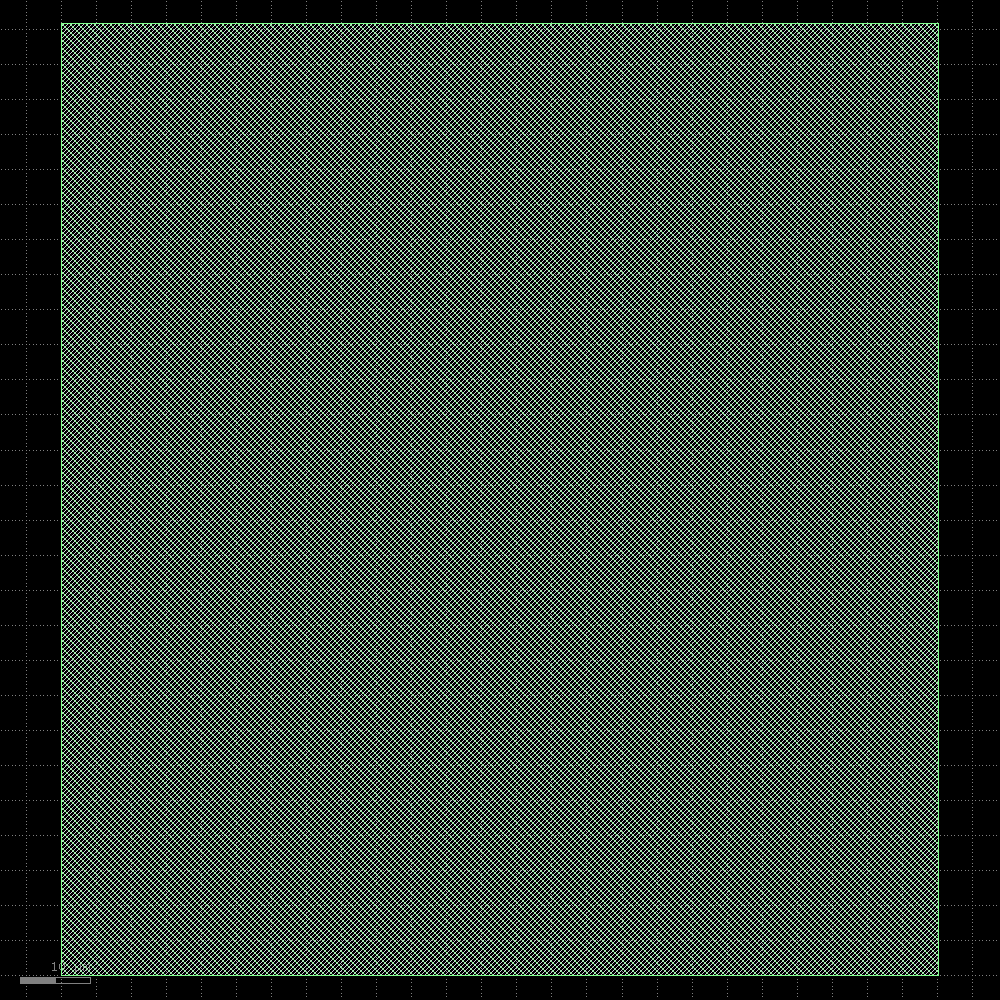

In [62]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [63]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[21:49:06] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=126621;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=357120;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:06] VERBOSE  Logging subprocess to                                                              ]8;id=270391;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=779627;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=812913;file:///content/openlane_run/11-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=846815;file:///content/openlane_run/11-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\11]8;;\]8;id=812913;file:///content/openlane_run/11-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                   

Reading OpenROAD database at '/content/openlane_run/10-openroad-floorplan/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 82 endcaps.

[INFO TAP-0005] Inserted 172 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/11-openroad-tapendcapinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/11-openroad-tapendcapinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/11-openroad-tapendcapinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/11-openroad-tapendcapinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/11-openroad-tapendcapinsertion/spm.sdc'…

{'nl': Path('/content/openlane_run/11-openroad-tapendcapinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/11-openroad-tapendcapinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/11-openroad-tapendcapinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/11-openroad-tapendcapinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/11-openroad-tapendcapinsertion/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 645, 'design__instance__area': Decimal('6732.71'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 22, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 645, 'design__instance__area__stdcell': Decimal('6732.71'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.529209'), 'design__instance__utilization__stdcell': Decimal('0.529209')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:49:14] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=268516;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=901108;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:14] VERBOSE  Logging subprocess to ]8;id=549891;file:///tmp/openlane_klayout_tmp_j3nwz2ta/klayout-render.log\..]8;;\]8;id=409856;file:///tmp/openlane_klayout_tmp_j3nwz2ta/klayout-render.log\/tmp/openlane_klayout_tmp_j3nwz2ta/]8;;\]8;id=151426;file:///tmp/openlane_klayout_tmp_j3nwz2ta/klayout-render.log\klayout-render.log]8;;\…     ]8;id=125705;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=516070;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.81s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
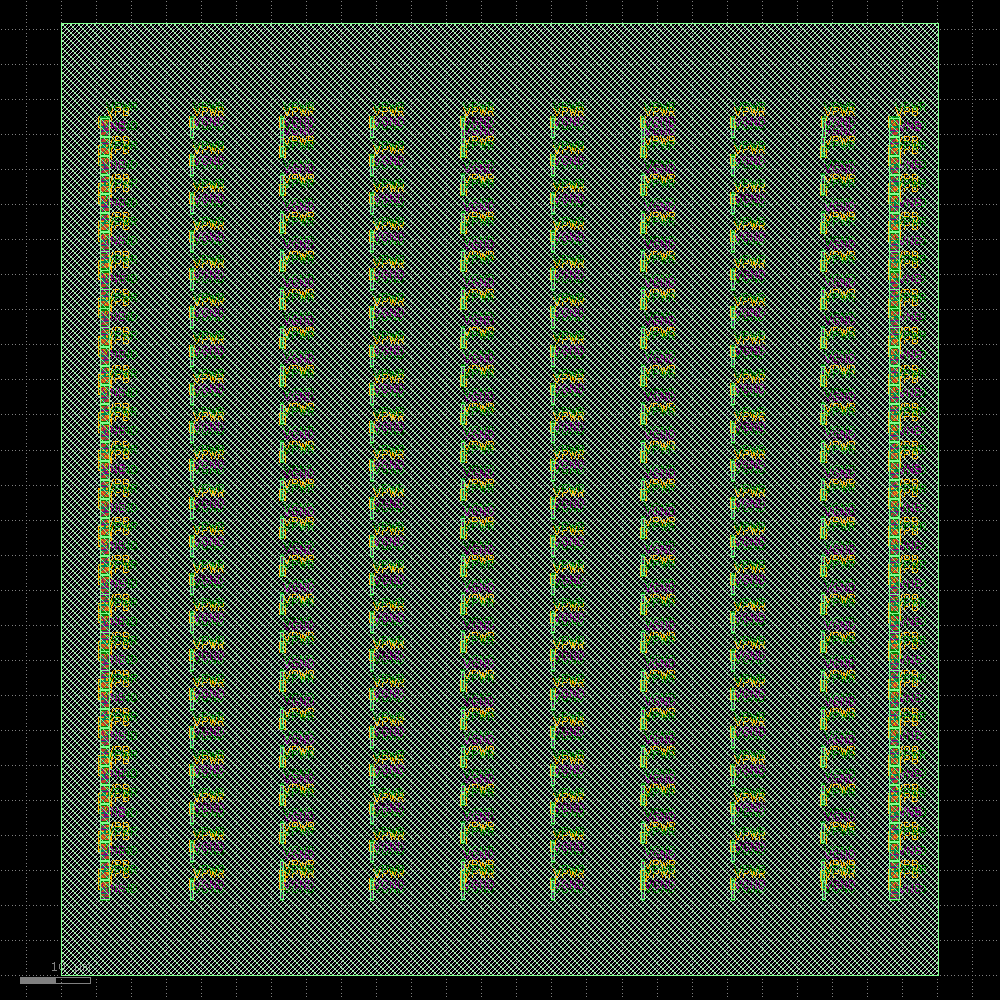

In [64]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [65]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[21:49:25] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=665842;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=324088;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:25] VERBOSE  Logging subprocess to                                                              ]8;id=102672;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=355043;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=354819;file:///content/openlane_run/12-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=120267;file:///content/openlane_run/12-openroad-ioplacement/openroad-ioplacement.log\12]8;;\]8;id=354819;file:///content/openlane_run/12-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/11-openroad-tapendcapinsertion/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           158

[INFO PPL-0002] Number of I/O             22

[INFO PPL-0003] Number of I/O w/sink      22

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 1788.71 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/12-openroad-ioplacement/spm.odb'…

Writing netlist to '/content/openlane_run/12-openroad-ioplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/12-openroad-ioplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/12-openroad-ioplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/12-openroad-ioplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/12-openroad-ioplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/12-openroad-ioplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/12-openroad-ioplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/12-openroad-ioplacement/spm.odb'), 'sdc': Path('/content/openlane_run/12-openroad-ioplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 645, 'design__instance__area': Decimal('6732.71'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 22, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 645, 'design__instance__area__stdcell': Decimal('6732.71'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.529209'), 'design__instance__utilization__stdcell': Decimal('0.529209'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:49:30] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=227542;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=435180;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:30] VERBOSE  Logging subprocess to ]8;id=976466;file:///tmp/openlane_klayout_tmp_p9u2n1h6/klayout-render.log\..]8;;\]8;id=981481;file:///tmp/openlane_klayout_tmp_p9u2n1h6/klayout-render.log\/tmp/openlane_klayout_tmp_p9u2n1h6/]8;;\]8;id=358133;file:///tmp/openlane_klayout_tmp_p9u2n1h6/klayout-render.log\klayout-render.log]8;;\…     ]8;id=340429;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=376647;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.81s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
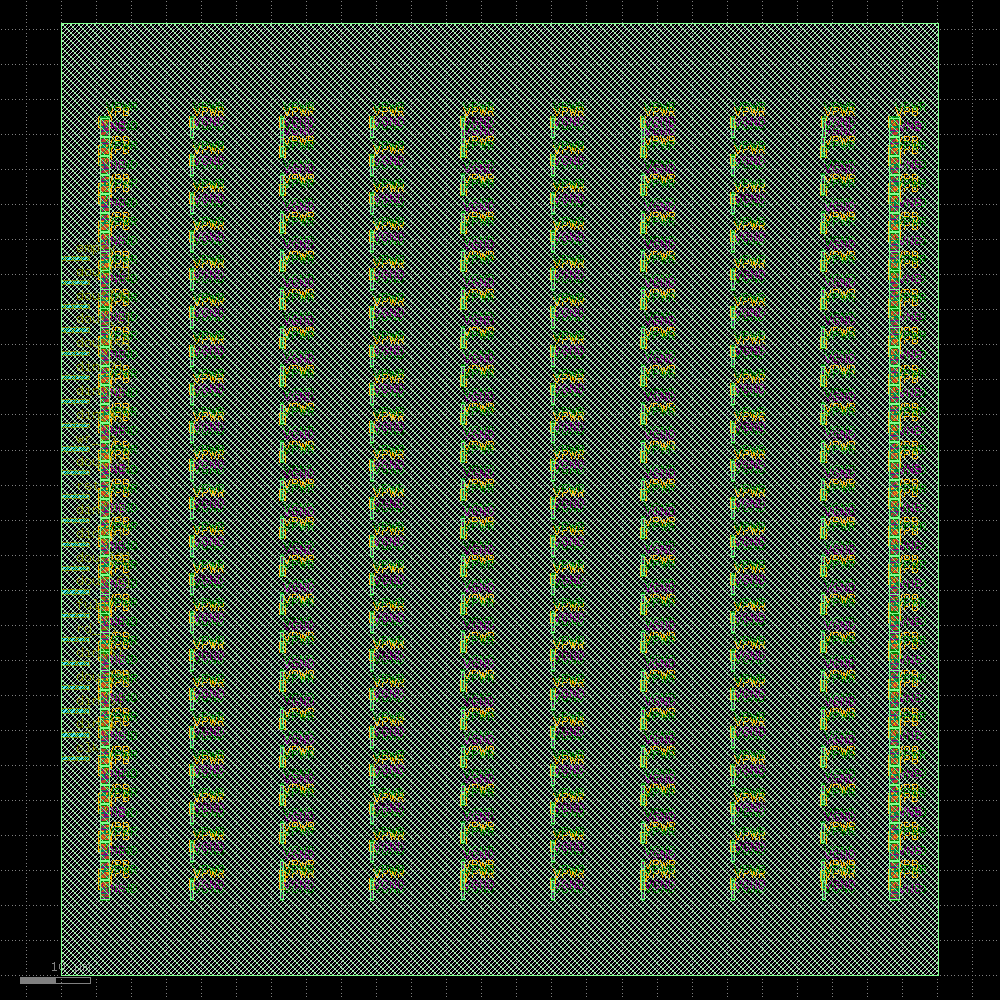

In [66]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [67]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[21:49:36] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=752187;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=236095;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:36] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=681636;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=672353;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[21:49:36] VERBOSE  Logging subprocess to                                                              ]8;id=82493;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=906407;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=367647;file:///content/openlane_run/13-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=992732;file:///content/openlane_run/13-openroad-generatepdn/openroad-generatepdn.log\13]8;;\]8;id=367647;file:///content/openlane_run/13-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/12-openroad-ioplacement/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/13-openroad-generatepdn/spm.odb'…

Writing netlist to '/content/openlane_run/13-openroad-generatepdn/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/13-openroad-generatepdn/spm.pnl.v'…

Writing layout to '/content/openlane_run/13-openroad-generatepdn/spm.def'…

Writing timing constraints to '/content/openlane_run/13-openroad-generatepdn/spm.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/13-openroad-generatepdn/spm.nl.v'), 'pnl': Path('/content/openlane_run/13-openroad-generatepdn/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/13-openroad-generatepdn/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/13-openroad-generatepdn/spm.odb'), 'sdc': Path('/content/openlane_run/13-openroad-generatepdn/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 645, 'design__instance__area': Decimal('6732.71'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 645, 'design__instance__area__stdcell': Decimal('6732.71'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.529209'), 'design__instance__utilization__stdcell': Decimal('0.529209'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:49:41] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=171031;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=40676;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:41] VERBOSE  Logging subprocess to ]8;id=822520;file:///tmp/openlane_klayout_tmp_edkxicvw/klayout-render.log\..]8;;\]8;id=336281;file:///tmp/openlane_klayout_tmp_edkxicvw/klayout-render.log\/tmp/openlane_klayout_tmp_edkxicvw/]8;;\]8;id=988879;file:///tmp/openlane_klayout_tmp_edkxicvw/klayout-render.log\klayout-render.log]8;;\…     ]8;id=294353;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=390462;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
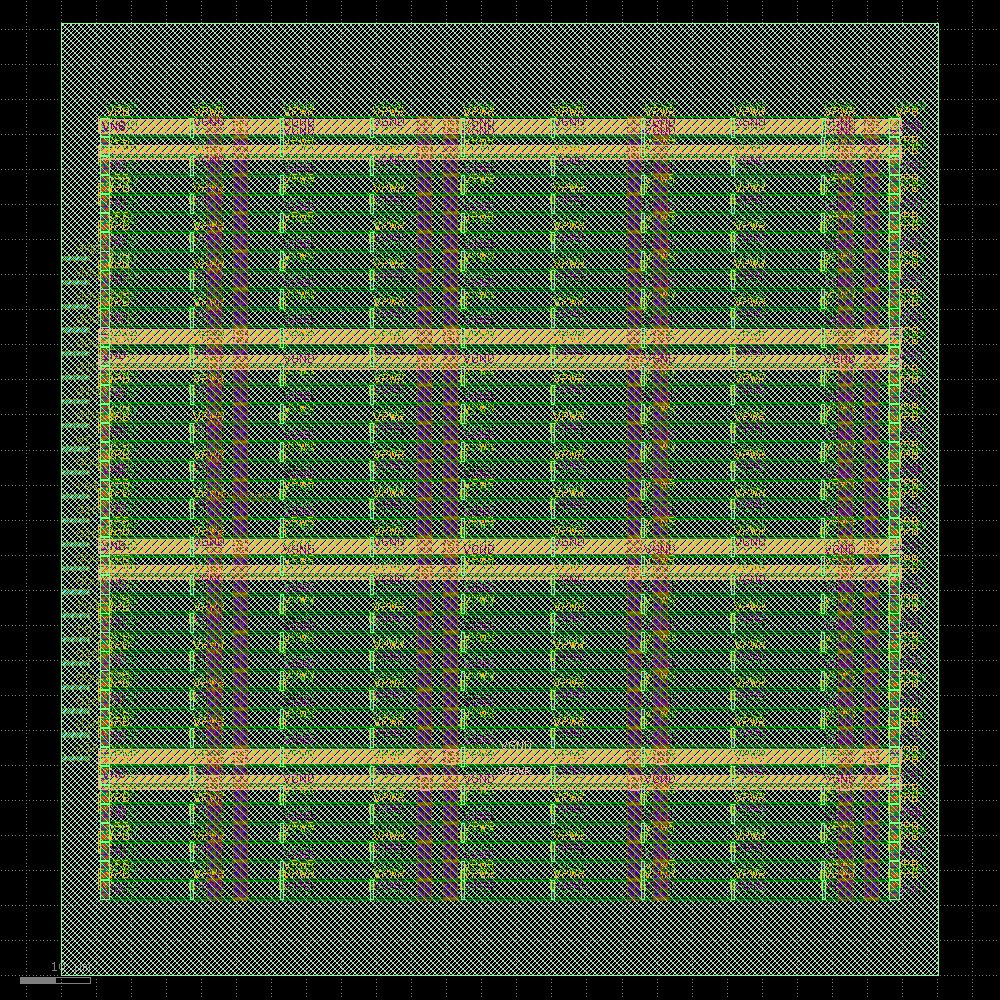

In [68]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [69]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[21:49:51] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=418429;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=678073;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:49:51] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=262688;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=478792;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 62.920900…                                                                     

[21:49:51] VERBOSE  Logging subprocess to                                                              ]8;id=531991;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=704051;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=799043;file:///content/openlane_run/14-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=308751;file:///content/openlane_run/14-openroad-globalplacement/openroad-globalplacement.log\14]8;;\]8;id=799043;file:///content/openlane_run/14-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/13-openroad-generatepdn/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 119.600 122.400 ) um

[INFO GPL-0006] NumInstances:               727

[INFO GPL-0007] NumPlaceInstances:          473

[INFO GPL-0008] NumFixedInstances:          254

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                    485

[INFO GPL-0011] NumPins:                   1813

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 125.210 135.930 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 119.600 122.400 ) um

[INFO GPL-0016] CoreArea:             12722.202 um^2

[INFO GPL-0017] NonPlaceInstsArea:      523.002 um^2

[INFO GPL-0018] PlaceInstsArea:        6517.501 um^2

[INFO GPL-0019] Util:                    53.426 %

[INFO GPL-0020] StdInstsArea:          6517.501 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00000006 HPWL: 6002220

[InitialPlace]  Iter: 2 CG residual: 0.00000006 HPWL: 5269614

[InitialPlace]  Iter: 3 CG residual: 0.00000007 HPWL: 5290942

[InitialPlace]  Iter: 4 CG residual: 0.00000009 HPWL: 5311776

[InitialPlace]  Iter: 5 CG residual: 0.00000012 HPWL: 5307451

[INFO GPL-0031] FillerInit:NumGCells:       557

[INFO GPL-0032] FillerInit:NumGNets:        485

[INFO GPL-0033] FillerInit:NumGPins:       1813

[INFO GPL-0023] TargetDensity:            0.629

[INFO GPL-0024] AvrgPlaceInstArea:       13.779 um^2

[INFO GPL-0025] IdealBinArea:            21.899 um^2

[INFO GPL-0026] IdealBinCnt:                580

[INFO GPL-0027] TotalBinArea:         12722.202 um^2

[INFO GPL-0028] BinCnt:        16     16

[INFO GPL-0029] BinSize: (  7.130  6.970 )

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter:    1 overflow: 0.979 HPWL: 1857846

[NesterovSolve] Iter:   10 overflow: 0.962 HPWL: 1838125

[NesterovSolve] Iter:   20 overflow: 0.962 HPWL: 1835994

[NesterovSolve] Iter:   30 overflow: 0.962 HPWL: 1834183

[NesterovSolve] Iter:   40 overflow: 0.962 HPWL: 1834033

[NesterovSolve] Iter:   50 overflow: 0.962 HPWL: 1831743

[NesterovSolve] Iter:   60 overflow: 0.962 HPWL: 1830692

[NesterovSolve] Iter:   70 overflow: 0.962 HPWL: 1830129

[NesterovSolve] Iter:   80 overflow: 0.962 HPWL: 1830606

[NesterovSolve] Iter:   90 overflow: 0.962 HPWL: 1831873

[NesterovSolve] Iter:  100 overflow: 0.962 HPWL: 1834961

[NesterovSolve] Iter:  110 overflow: 0.962 HPWL: 1840363

[NesterovSolve] Iter:  120 overflow: 0.962 HPWL: 1849354

[NesterovSolve] Iter:  130 overflow: 0.962 HPWL: 1865771

[NesterovSolve] Iter:  140 overflow: 0.961 HPWL: 1893913

[NesterovSolve] Iter:  150 overflow: 0.955 HPWL: 1947546

[NesterovSolve] Iter:  160 overflow: 0.948 HPWL: 2042019

[NesterovSolve] Iter:  170 overflow: 0.943 HPWL: 2224057

[NesterovSolve] Iter:  180 overflow: 0.922 HPWL: 2456258

[NesterovSolve] Iter:  190 overflow: 0.899 HPWL: 2690143

[NesterovSolve] Iter:  200 overflow: 0.884 HPWL: 2967092

[NesterovSolve] Iter:  210 overflow: 0.862 HPWL: 3416676

[NesterovSolve] Iter:  220 overflow: 0.830 HPWL: 3851901

[NesterovSolve] Iter:  230 overflow: 0.797 HPWL: 4241878

[INFO GPL-0100] worst slack 5.94e-09

[INFO GPL-0103] Weighted 48 nets.

[NesterovSolve] Iter:  240 overflow: 0.757 HPWL: 4835175

[NesterovSolve] Iter:  250 overflow: 0.726 HPWL: 5161734

[NesterovSolve] Iter:  260 overflow: 0.692 HPWL: 5714806

[NesterovSolve] Iter:  270 overflow: 0.644 HPWL: 6160098

[INFO GPL-0100] worst slack 5.88e-09

[INFO GPL-0103] Weighted 48 nets.

[NesterovSolve] Iter:  280 overflow: 0.600 HPWL: 6620147

[NesterovSolve] Snapshot saved at iter = 279

[NesterovSolve] Iter:  290 overflow: 0.557 HPWL: 7167346

[NesterovSolve] Iter:  300 overflow: 0.503 HPWL: 7596695

[INFO GPL-0100] worst slack 5.83e-09

[INFO GPL-0103] Weighted 47 nets.

[NesterovSolve] Iter:  310 overflow: 0.449 HPWL: 7923834

[NesterovSolve] Iter:  320 overflow: 0.388 HPWL: 8068378

[NesterovSolve] Iter:  330 overflow: 0.322 HPWL: 8164983

[NesterovSolve] Iter:  340 overflow: 0.287 HPWL: 8243236

[INFO GPL-0100] worst slack 5.79e-09

[INFO GPL-0103] Weighted 46 nets.

[NesterovSolve] Iter:  350 overflow: 0.243 HPWL: 8360098

[NesterovSolve] Iter:  360 overflow: 0.218 HPWL: 8521477

[INFO GPL-0100] worst slack 5.77e-09

[INFO GPL-0103] Weighted 48 nets.

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      18   19

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 342

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9702

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0078] FinalRC lower than minRC (1e+30), min RC updated.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.629

[INFO GPL-0049] WhiteSpaceArea:       12199.200 um^2

[INFO GPL-0050] NesterovInstsArea:     6517.501 um^2

[INFO GPL-0051] TotalFillerArea:       1158.345 um^2

[INFO GPL-0052] TotalGCellsArea:       7675.846 um^2

[INFO GPL-0053] ExpectedGCellsArea:    7675.846 um^2

[INFO GPL-0054] NewTargetDensity:         0.629

[INFO GPL-0055] NewWhiteSpaceArea:    12199.200 um^2

[INFO GPL-0056] MovableArea:           7675.846 um^2

[INFO GPL-0057] NewNesterovInstArea:   6517.501 um^2

[INFO GPL-0058] NewTotalFillerArea:    1158.345 um^2

[INFO GPL-0059] NewTotalGCellsArea:    7675.846 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  370 overflow: 0.582 HPWL: 6834675

[NesterovSolve] Iter:  380 overflow: 0.548 HPWL: 7254511

[NesterovSolve] Iter:  390 overflow: 0.505 HPWL: 7595890

[NesterovSolve] Iter:  400 overflow: 0.460 HPWL: 7820072

[NesterovSolve] Iter:  410 overflow: 0.411 HPWL: 7962214

[NesterovSolve] Iter:  420 overflow: 0.364 HPWL: 8072674

[NesterovSolve] Iter:  430 overflow: 0.313 HPWL: 8120009

[NesterovSolve] Iter:  440 overflow: 0.270 HPWL: 8267495

[NesterovSolve] Iter:  450 overflow: 0.242 HPWL: 8412174

[NesterovSolve] Iter:  460 overflow: 0.206 HPWL: 8552794

[INFO GPL-0075] Routability numCall: 2 inflationIterCnt: 2 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      18   19

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 342

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9883

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 1.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.629

[INFO GPL-0049] WhiteSpaceArea:       12199.200 um^2

[INFO GPL-0050] NesterovInstsArea:     6517.501 um^2

[INFO GPL-0051] TotalFillerArea:       1158.345 um^2

[INFO GPL-0052] TotalGCellsArea:       7675.846 um^2

[INFO GPL-0053] ExpectedGCellsArea:    7675.846 um^2

[INFO GPL-0054] NewTargetDensity:         0.629

[INFO GPL-0055] NewWhiteSpaceArea:    12199.200 um^2

[INFO GPL-0056] MovableArea:           7675.846 um^2

[INFO GPL-0057] NewNesterovInstArea:   6517.501 um^2

[INFO GPL-0058] NewTotalFillerArea:    1158.345 um^2

[INFO GPL-0059] NewTotalGCellsArea:    7675.846 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  470 overflow: 0.578 HPWL: 6913156

[NesterovSolve] Iter:  480 overflow: 0.540 HPWL: 7324277

[NesterovSolve] Iter:  490 overflow: 0.496 HPWL: 7651658

[NesterovSolve] Iter:  500 overflow: 0.451 HPWL: 7861404

[NesterovSolve] Iter:  510 overflow: 0.402 HPWL: 7973581

[NesterovSolve] Iter:  520 overflow: 0.353 HPWL: 8090783

[NesterovSolve] Iter:  530 overflow: 0.305 HPWL: 8157930

[NesterovSolve] Iter:  540 overflow: 0.266 HPWL: 8299395

[NesterovSolve] Iter:  550 overflow: 0.233 HPWL: 8452096

[NesterovSolve] Iter:  560 overflow: 0.201 HPWL: 8567880

[INFO GPL-0075] Routability numCall: 3 inflationIterCnt: 3 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      18   19

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 342

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9883

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 2.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.629

[INFO GPL-0049] WhiteSpaceArea:       12199.200 um^2

[INFO GPL-0050] NesterovInstsArea:     6517.501 um^2

[INFO GPL-0051] TotalFillerArea:       1158.345 um^2

[INFO GPL-0052] TotalGCellsArea:       7675.846 um^2

[INFO GPL-0053] ExpectedGCellsArea:    7675.846 um^2

[INFO GPL-0054] NewTargetDensity:         0.629

[INFO GPL-0055] NewWhiteSpaceArea:    12199.200 um^2

[INFO GPL-0056] MovableArea:           7675.846 um^2

[INFO GPL-0057] NewNesterovInstArea:   6517.501 um^2

[INFO GPL-0058] NewTotalFillerArea:    1158.345 um^2

[INFO GPL-0059] NewTotalGCellsArea:    7675.846 um^2

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  570 overflow: 0.573 HPWL: 7002755

[NesterovSolve] Iter:  580 overflow: 0.532 HPWL: 7393743

[NesterovSolve] Iter:  590 overflow: 0.487 HPWL: 7697493

[NesterovSolve] Iter:  600 overflow: 0.441 HPWL: 7894368

[NesterovSolve] Iter:  610 overflow: 0.394 HPWL: 7994893

[NesterovSolve] Iter:  620 overflow: 0.342 HPWL: 8094350

[NesterovSolve] Iter:  630 overflow: 0.297 HPWL: 8198282

[NesterovSolve] Iter:  640 overflow: 0.264 HPWL: 8333960

[NesterovSolve] Iter:  650 overflow: 0.226 HPWL: 8476346

[INFO GPL-0075] Routability numCall: 4 inflationIterCnt: 4 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      18   19

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 342

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 1.0000

[INFO GPL-0068] 2.0%RC: 1.0000

[INFO GPL-0069] 5.0%RC: 0.9883

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 1.0000

[INFO GPL-0079] MinRC (1) violation occurred, total count: 3.

[INFO GPL-0045] InflatedAreaDelta:        0.000 um^2

[INFO GPL-0046] TargetDensity:            0.629

Revert Routability Procedure. Target density higher than max, or minRC max violations.

[INFO GPL-0080] minRcViolatedCnt: 3

[INFO GPL-0047] SavedMinRC: 1.0000

[INFO GPL-0048] SavedTargetDensity: 0.6292

[NesterovSolve] Revert back to snapshot coordi

[NesterovSolve] Iter:  660 overflow: 0.596 HPWL: 6662019

[NesterovSolve] Iter:  670 overflow: 0.564 HPWL: 7104800

[NesterovSolve] Iter:  680 overflow: 0.524 HPWL: 7462667

[NesterovSolve] Iter:  690 overflow: 0.478 HPWL: 7743893

[NesterovSolve] Iter:  700 overflow: 0.432 HPWL: 7920611

[NesterovSolve] Iter:  710 overflow: 0.385 HPWL: 8035835

[NesterovSolve] Iter:  720 overflow: 0.329 HPWL: 8097150

[NesterovSolve] Iter:  730 overflow: 0.285 HPWL: 8230792

[NesterovSolve] Iter:  740 overflow: 0.258 HPWL: 8377899

[NesterovSolve] Iter:  750 overflow: 0.221 HPWL: 8500464

[NesterovSolve] Iter:  760 overflow: 0.195 HPWL: 8600304

[NesterovSolve] Iter:  770 overflow: 0.165 HPWL: 8655835

[INFO GPL-0100] worst slack 5.75e-09

[INFO GPL-0103] Weighted 47 nets.

[NesterovSolve] Iter:  780 overflow: 0.137 HPWL: 8694178

[NesterovSolve] Iter:  790 overflow: 0.118 HPWL: 8741781

[NesterovSolve] Finished with Overflow: 0.099683

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/14-openroad-globalplacement/spm.odb'…

Writing netlist to '/content/openlane_run/14-openroad-globalplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/14-openroad-globalplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/14-openroad-globalplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/14-openroad-globalplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/14-openroad-globalplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/14-openroad-globalplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/14-openroad-globalplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/14-openroad-globalplacement/spm.odb'), 'sdc': Path('/content/openlane_run/14-openroad-globalplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 645, 'design__instance__area': Decimal('6732.71'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 645, 'design__instance__area__stdcell': Decimal('6732.71'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.529209'), 'design__instance__utilization__stdcell': Decimal('0.529209'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:50:00] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=222657;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=172453;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:50:00] VERBOSE  Logging subprocess to ]8;id=208183;file:///tmp/openlane_klayout_tmp_tebnijn4/klayout-render.log\..]8;;\]8;id=567009;file:///tmp/openlane_klayout_tmp_tebnijn4/klayout-render.log\/tmp/openlane_klayout_tmp_tebnijn4/]8;;\]8;id=897817;file:///tmp/openlane_klayout_tmp_tebnijn4/klayout-render.log\klayout-render.log]8;;\…     ]8;id=652253;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=911979;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 3.45s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
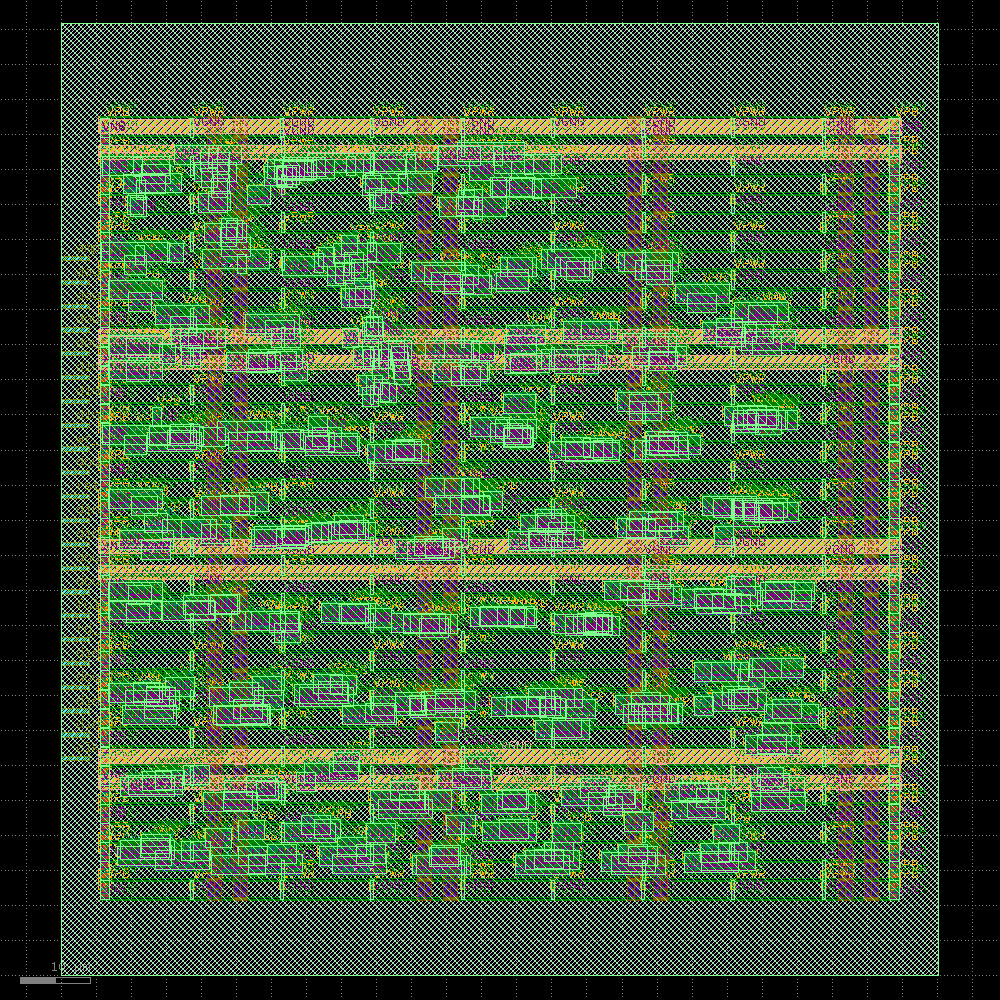

In [70]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [71]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[21:50:50] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=224426;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=198294;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:50:50] VERBOSE  Logging subprocess to                                                              ]8;id=475630;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=380408;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=248548;file:///content/openlane_run/15-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=996141;file:///content/openlane_run/15-openroad-detailedplacement/openroad-detailedplacement.log\15]8;;\]8;id=248548;file:///content/openlane_run/15-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                     

Reading OpenROAD database at '/content/openlane_run/14-openroad-globalplacement/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement       1601.3 u

average displacement        2.2 u

max displacement            9.4 u

original HPWL            8759.7 u

legalized HPWL          10656.4 u

delta HPWL                   22 %

[INFO DPL-0020] Mirrored 144 instances

[INFO DPL-0021] HPWL before           10656.4 u

[INFO DPL-0022] HPWL after            10395.2 u

[INFO DPL-0023] HPWL delta               -2.5 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/15-openroad-detailedplacement/spm.odb'…

Writing netlist to '/content/openlane_run/15-openroad-detailedplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/15-openroad-detailedplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/15-openroad-detailedplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/15-openroad-detailedplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/15-openroad-detailedplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/15-openroad-detailedplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/15-openroad-detailedplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/15-openroad-detailedplacement/spm.odb'), 'sdc': Path('/content/openlane_run/15-openroad-detailedplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 645, 'design__instance__area': Decimal('6732.71'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 645, 'design__instance__area__stdcell': Decimal('6732.71'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.529209'), 'design__instance__utilization__stdcell': Decimal('0.529209'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('1601.33'), 'design__instance__displacement__mean': Decimal('2.202'), 'design__instance__displacement__max': Decimal('9.399'), 'route__wirelength__estimated': Decimal('10656.4'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:50:59] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=275195;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=208304;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:50:59] VERBOSE  Logging subprocess to ]8;id=413615;file:///tmp/openlane_klayout_tmp_79o2at2r/klayout-render.log\..]8;;\]8;id=665060;file:///tmp/openlane_klayout_tmp_79o2at2r/klayout-render.log\/tmp/openlane_klayout_tmp_79o2at2r/]8;;\]8;id=812850;file:///tmp/openlane_klayout_tmp_79o2at2r/klayout-render.log\klayout-render.log]8;;\…     ]8;id=217640;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=343390;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
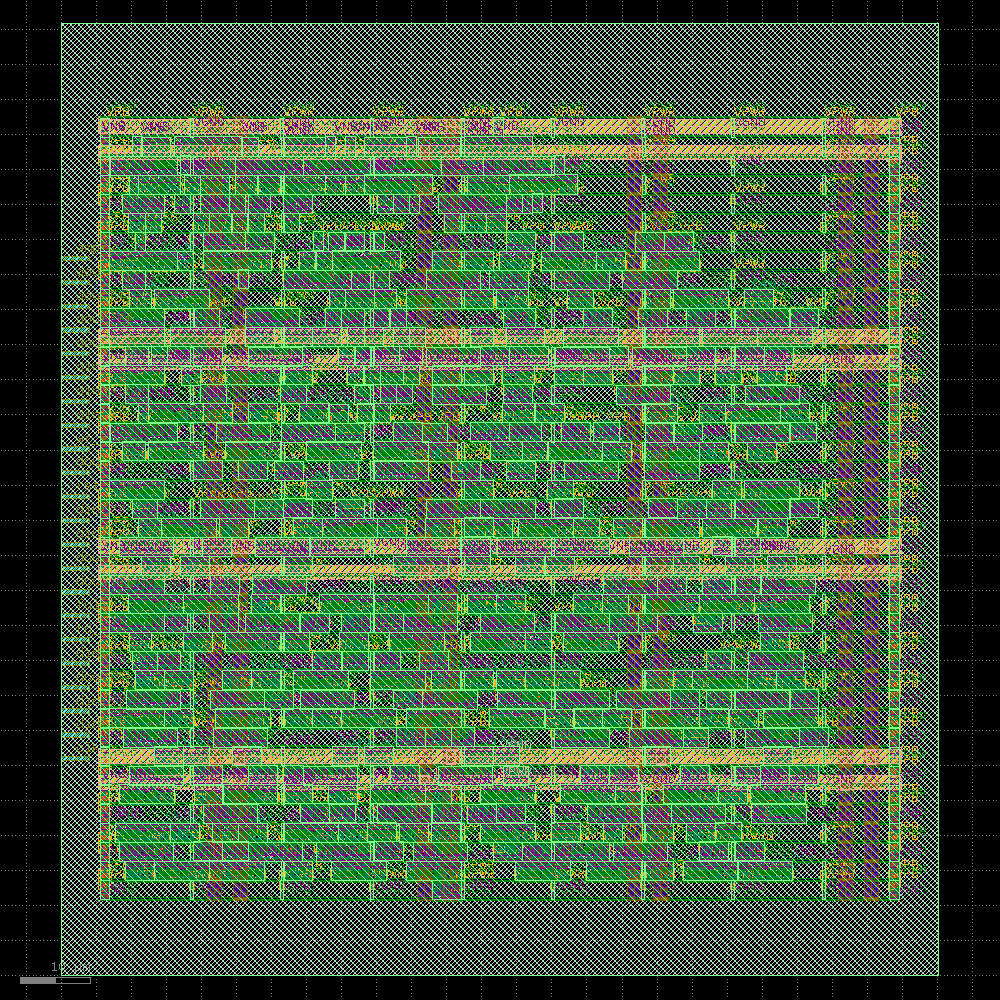

In [72]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [73]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[21:51:10] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=465344;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=730985;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:51:10] VERBOSE  Logging subprocess to ]8;id=291576;file:///content/openlane_run/16-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=541501;file:///content/openlane_run/16-openroad-cts/openroad-cts.log\16]8;;\]8;id=291576;file:///content/openlane_run/16-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…               ]8;id=193803;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=209095;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/15-openroad-detailedplacement/spm.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 151 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 151.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(8545, 15020), (105995, 118380)].

[INFO CTS-0024]  Normalized sink region: [(0.628309, 1.10441), (7.79375, 8.70441)].

[INFO CTS-0025]     Width:  7.1654.

[INFO CTS-0026]     Height: 7.6000.

Level 1

Direction: Vertical

Sinks per sub-region: 76

Sub-region size: 7.1654 X 3.8000

[INFO CTS-0034]     Segment length (rounded): 2.

Level 2

Direction: Horizontal

Sinks per sub-region: 38

Sub-region size: 3.5827 X 3.8000

[INFO CTS-0034]     Segment length (rounded): 2.

Level 3

Direction: Vertical

Sinks per sub-region: 19

Sub-region size: 3.5827 X 1.9000

[INFO CTS-0034]     Segment length (rounded): 1.

Level 4

Direction: Horizontal

Sinks per sub-region: 10

Sub-region size: 1.7914 X 1.9000

[INFO CTS-0034]     Segment length (rounded): 1.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 151.

[INFO CTS-0018]     Created 17 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 17 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 5:1, 7:4, 9:3, 10:2, 11:3, 12:1, 13:2..

[INFO CTS-0017]     Max level of the clock tree: 4.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 165

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 161.36 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 14

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/16-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/16-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/16-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/16-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/16-openroad-cts/spm.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        263.1 u

average displacement        0.3 u

max displacement            9.9 u

original HPWL           11119.6 u

legalized HPWL          11657.3 u

delta HPWL                    5 %

[INFO DPL-0020] Mirrored 147 instances

[INFO DPL-0021] HPWL before           11657.3 u

[INFO DPL-0022] HPWL after            11354.5 u

[INFO DPL-0023] HPWL delta               -2.6 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/16-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/16-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/16-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/16-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/16-openroad-cts/spm.sdc'…

{'nl': Path('/content/openlane_run/16-openroad-cts/spm.nl.v'), 'pnl': Path('/content/openlane_run/16-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/16-openroad-cts/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/16-openroad-cts/spm.odb'), 'sdc': Path('/content/openlane_run/16-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 676, 'design__instance__area': Decimal('7170.63'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 676, 'design__instance__area__stdcell': Decimal('7170.63'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.563631'), 'design__instance__utilization__stdcell': Decimal('0.563631'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('263.125'), 'design__instance__displacement__mean': Decimal('0.347'), 'design__instance__displacement__max': Decimal('9.878'), 'route__wirelength__estimated': Decimal('11657.3'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:51:25] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=969566;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=940216;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:51:25] VERBOSE  Logging subprocess to ]8;id=505417;file:///tmp/openlane_klayout_tmp_kxilbmn6/klayout-render.log\..]8;;\]8;id=406297;file:///tmp/openlane_klayout_tmp_kxilbmn6/klayout-render.log\/tmp/openlane_klayout_tmp_kxilbmn6/]8;;\]8;id=225402;file:///tmp/openlane_klayout_tmp_kxilbmn6/klayout-render.log\klayout-render.log]8;;\…     ]8;id=534748;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=806759;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 12.64s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
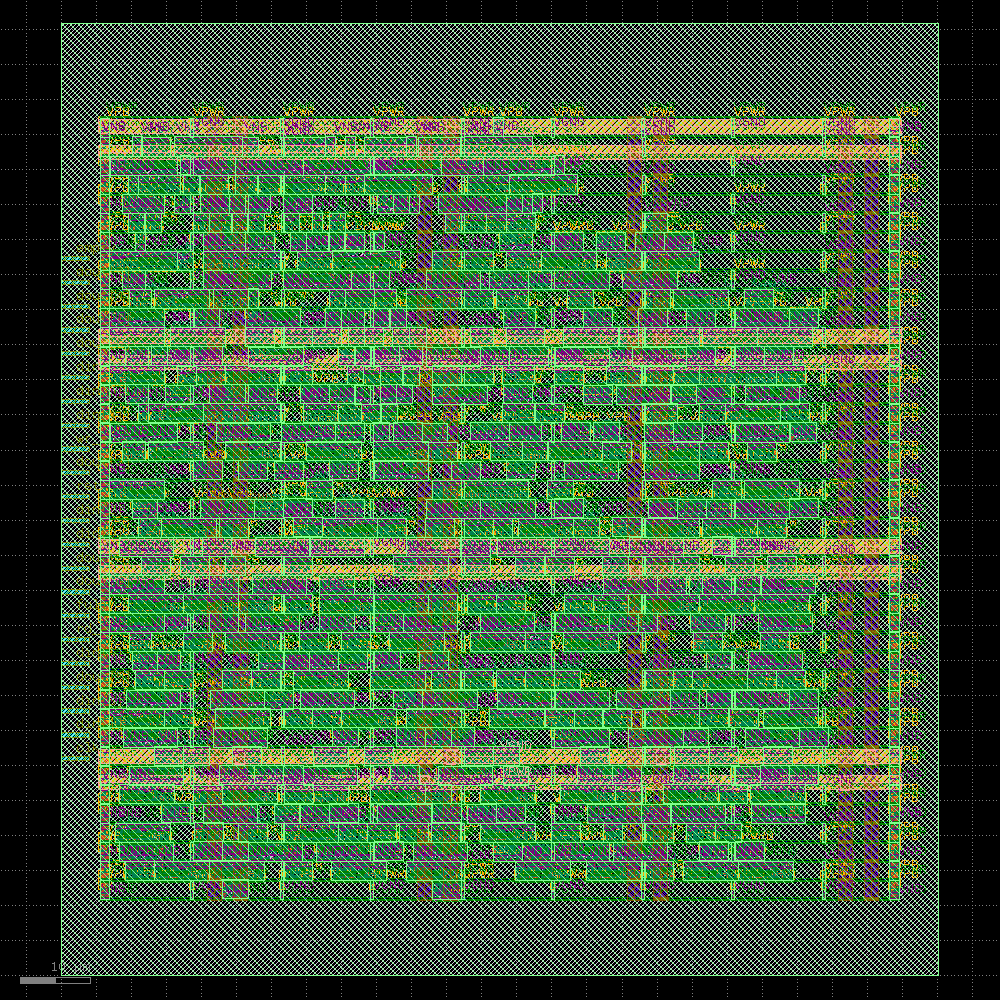

In [74]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [76]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[21:51:52] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=325613;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=162039;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:51:52] VERBOSE  Logging subprocess to                                                              ]8;id=729149;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=941649;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=446725;file:///content/openlane_run/17-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=287604;file:///content/openlane_run/17-openroad-globalrouting/openroad-globalrouting.log\17]8;;\]8;id=446725;file:///content/openlane_run/17-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/16-openroad-cts/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 18 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 21

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 2166

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       7072          3395          51.99%

met2       Vertical         5183          3234          37.60%

met3       Horizontal       3536          2261          36.06%

met4       Vertical         2096          1026          51.05%

met5       Horizontal        700           289          58.71%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 3173

[INFO GRT-0198] Via related Steiner nodes: 83

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 4022

[INFO GRT-0112] Final usage 3D: 14233

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              3395           998           29.40%             0 /  0 /  0

met2              3234          1092           33.77%             0 /  0 /  0

met3              2261            68            3.01%             0 /  0 /  0

met4              1026             9            0.88%             0 /  0 /  0

met5               289             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total            10205          2167           21.23%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 24633 um

[INFO GRT-0014] Routed nets: 502

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/17-openroad-globalrouting/spm.odb'…

Writing layout to '/content/openlane_run/17-openroad-globalrouting/spm.def'…

{'nl': Path('/content/openlane_run/16-openroad-cts/spm.nl.v'), 'pnl': Path('/content/openlane_run/16-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/17-openroad-globalrouting/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/17-openroad-globalrouting/spm.odb'), 'sdc': Path('/content/openlane_run/16-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 676, 'design__instance__area': Decimal('7170.63'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 676, 'design__instance__area__stdcell': Decimal('7170.63'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.563631'), 'design__instance__utilization__stdcell': Decimal('0.563631'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('263.125'), 'design__instance__displacement__mean': Decimal('0.347'), 'design__instance__displacement__max': Decimal('9.878'), 'route__wirelength__estimated': Decimal('11657.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [77]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[21:51:58] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=82814;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=39020;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:51:58] INFO     Running TritonRoute with 2 threads…                                            ]8;id=696296;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=279428;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[21:51:58] VERBOSE  Logging subprocess to                                                              ]8;id=798000;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=105537;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=923975;file:///content/openlane_run/18-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=655754;file:///content/openlane_run/18-openroad-detailedrouting/openroad-detailedrouting.log\18]8;;\]8;id=923975;file:///content/openlane_run/18-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/17-openroad-globalrouting/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=421242;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=347727;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=133896;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=74802;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=769920;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=843822;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=164789;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=723950;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=186068;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=277471;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=523790;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=802123;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=774621;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=194439;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=961216;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=370082;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=879500;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=24939;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[21:51:59] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=652971;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=814545;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   spm

Die area:                 ( 0 0 ) ( 125210 135930 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     758

Number of terminals:      24

Number of snets:          2

Number of nets:           502

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 104.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 21185.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 3075.

[INFO DRT-0033] via shape region query size = 1008.

[INFO DRT-0033] met2 shape region query size = 336.

[INFO DRT-0033] via2 shape region query size = 840.

[INFO DRT-0033] met3 shape region query size = 526.

[INFO DRT-0033] via3 shape region query size = 840.

[INFO DRT-0033] met4 shape region query size = 216.

[INFO DRT-0033] via4 shape region query size = 32.

[INFO DRT-0033] met5 shape region query size = 48.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 360 pins.

[INFO DRT-0081]   Complete 98 unique inst patterns.

[INFO DRT-0084]   Complete 326 groups.

#scanned instances     = 758

#unique  instances     = 104

#stdCellGenAp          = 2533

#stdCellValidPlanarAp  = 38

#stdCellValidViaAp     = 1938

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 1839

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:21, elapsed time = 00:00:12, memory = 117.56 (MB), peak = 250.45 (MB)

Number of guides:     4200

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 18 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 19 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 1448.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 1174.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 644.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 35.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 2.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 2094 vertical wires in 1 frboxes and 1209 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 267 vertical wires in 1 frboxes and 367 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 126.42 (MB), peak = 250.45 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 126.42 (MB), peak = 250.45 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:01, memory = 139.98 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:01, memory = 141.38 (MB).

Completing 30% with 0 violations.

elapsed time = 00:00:02, memory = 148.18 (MB).

Completing 40% with 0 violations.

elapsed time = 00:00:02, memory = 140.07 (MB).

Completing 50% with 33 violations.

elapsed time = 00:00:03, memory = 154.76 (MB).

Completing 60% with 33 violations.

elapsed time = 00:00:06, memory = 148.06 (MB).

Completing 70% with 115 violations.

elapsed time = 00:00:07, memory = 158.37 (MB).

Completing 80% with 115 violations.

elapsed time = 00:00:09, memory = 162.75 (MB).

Completing 90% with 188 violations.

elapsed time = 00:00:16, memory = 167.13 (MB).

Completing 100% with 281 violations.

elapsed time = 00:00:16, memory = 167.13 (MB).

[INFO DRT-0199]   Number of violations = 513.

Viol/Layer         li1   met1   met2   met3

Metal Spacing        3     63     13      0

Recheck              0    145     82      5

Short                0    155     47      0

[INFO DRT-0267] cpu time = 00:00:19, elapsed time = 00:00:17, memory = 500.09 (MB), peak = 500.09 (MB)

Total wire length = 15661 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7578 um.

Total wire length on LAYER met2 = 7319 um.

Total wire length on LAYER met3 = 706 um.

Total wire length on LAYER met4 = 57 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3926.

Up-via summary (total 3926):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2045

met2      57

met3       4

met4       0

-----------------------

3926

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 513 violations.

elapsed time = 00:00:00, memory = 500.09 (MB).

Completing 20% with 513 violations.

elapsed time = 00:00:00, memory = 500.09 (MB).

Completing 30% with 513 violations.

elapsed time = 00:00:01, memory = 500.09 (MB).

Completing 40% with 513 violations.

elapsed time = 00:00:01, memory = 500.09 (MB).

Completing 50% with 470 violations.

elapsed time = 00:00:03, memory = 504.73 (MB).

Completing 60% with 470 violations.

elapsed time = 00:00:03, memory = 506.53 (MB).

Completing 70% with 386 violations.

elapsed time = 00:00:04, memory = 512.72 (MB).

Completing 80% with 386 violations.

elapsed time = 00:00:06, memory = 512.72 (MB).

Completing 90% with 297 violations.

elapsed time = 00:00:09, memory = 512.82 (MB).

Completing 100% with 136 violations.

elapsed time = 00:00:09, memory = 512.82 (MB).

[INFO DRT-0199]   Number of violations = 136.

Viol/Layer        met1   met2

Metal Spacing       22      3

Short              101     10

[INFO DRT-0267] cpu time = 00:00:14, elapsed time = 00:00:10, memory = 512.82 (MB), peak = 525.61 (MB)

Total wire length = 15472 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7559 um.

Total wire length on LAYER met2 = 7138 um.

Total wire length on LAYER met3 = 719 um.

Total wire length on LAYER met4 = 55 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3911.

Up-via summary (total 3911):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2020

met2      67

met3       4

met4       0

-----------------------

3911

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 136 violations.

elapsed time = 00:00:00, memory = 512.82 (MB).

Completing 20% with 136 violations.

elapsed time = 00:00:03, memory = 516.17 (MB).

Completing 30% with 134 violations.

elapsed time = 00:00:03, memory = 516.17 (MB).

Completing 40% with 134 violations.

elapsed time = 00:00:03, memory = 516.17 (MB).

Completing 50% with 134 violations.

elapsed time = 00:00:06, memory = 516.95 (MB).

Completing 60% with 105 violations.

elapsed time = 00:00:06, memory = 516.95 (MB).

Completing 70% with 105 violations.

elapsed time = 00:00:09, memory = 516.95 (MB).

Completing 80% with 85 violations.

elapsed time = 00:00:09, memory = 516.95 (MB).

Completing 90% with 85 violations.

elapsed time = 00:00:10, memory = 516.95 (MB).

Completing 100% with 94 violations.

elapsed time = 00:00:14, memory = 516.95 (MB).

[INFO DRT-0199]   Number of violations = 94.

Viol/Layer        mcon   met1   met2

Cut Spacing          1      0      0

Metal Spacing        0     15      2

Short                0     70      6

[INFO DRT-0267] cpu time = 00:00:15, elapsed time = 00:00:14, memory = 516.95 (MB), peak = 525.61 (MB)

Total wire length = 15302 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7423 um.

Total wire length on LAYER met2 = 7088 um.

Total wire length on LAYER met3 = 736 um.

Total wire length on LAYER met4 = 53 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3890.

Up-via summary (total 3890):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2000

met2      66

met3       4

met4       0

-----------------------

3890

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 94 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 20% with 94 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 30% with 94 violations.

elapsed time = 00:00:01, memory = 516.95 (MB).

Completing 40% with 94 violations.

elapsed time = 00:00:01, memory = 516.95 (MB).

Completing 50% with 77 violations.

elapsed time = 00:00:01, memory = 516.95 (MB).

Completing 60% with 77 violations.

elapsed time = 00:00:03, memory = 516.95 (MB).

Completing 70% with 54 violations.

elapsed time = 00:00:03, memory = 516.95 (MB).

Completing 80% with 54 violations.

elapsed time = 00:00:04, memory = 516.95 (MB).

Completing 90% with 35 violations.

elapsed time = 00:00:06, memory = 516.95 (MB).

Completing 100% with 1 violations.

elapsed time = 00:00:06, memory = 516.95 (MB).

[INFO DRT-0199]   Number of violations = 1.

Viol/Layer        met1

Metal Spacing        1

[INFO DRT-0267] cpu time = 00:00:06, elapsed time = 00:00:06, memory = 516.95 (MB), peak = 525.61 (MB)

Total wire length = 15293 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7003 um.

Total wire length on LAYER met2 = 7054 um.

Total wire length on LAYER met3 = 1109 um.

Total wire length on LAYER met4 = 125 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3955.

Up-via summary (total 3955):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2007

met2     117

met3      11

met4       0

-----------------------

3955

[INFO DRT-0195] Start 4th optimization iteration.

Completing 10% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 20% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 30% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 40% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 50% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 60% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 70% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 80% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 90% with 1 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

Completing 100% with 0 violations.

elapsed time = 00:00:00, memory = 516.95 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 516.95 (MB), peak = 525.61 (MB)

Total wire length = 15289 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7003 um.

Total wire length on LAYER met2 = 7051 um.

Total wire length on LAYER met3 = 1109 um.

Total wire length on LAYER met4 = 125 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3956.

Up-via summary (total 3956):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2008

met2     117

met3      11

met4       0

-----------------------

3956

[INFO DRT-0198] Complete detail routing.

Total wire length = 15289 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 7003 um.

Total wire length on LAYER met2 = 7051 um.

Total wire length on LAYER met3 = 1109 um.

Total wire length on LAYER met4 = 125 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 3956.

Up-via summary (total 3956):

-----------------------

FR_MASTERSLICE       0

li1    1820

met1    2008

met2     117

met3      11

met4       0

-----------------------

3956

[INFO DRT-0267] cpu time = 00:00:57, elapsed time = 00:00:49, memory = 516.95 (MB), peak = 525.61 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/18-openroad-detailedrouting/spm.odb'…

Writing netlist to '/content/openlane_run/18-openroad-detailedrouting/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/18-openroad-detailedrouting/spm.pnl.v'…

Writing layout to '/content/openlane_run/18-openroad-detailedrouting/spm.def'…

Writing timing constraints to '/content/openlane_run/18-openroad-detailedrouting/spm.sdc'…

{'nl': Path('/content/openlane_run/18-openroad-detailedrouting/spm.nl.v'), 'pnl': Path('/content/openlane_run/18-openroad-detailedrouting/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/18-openroad-detailedrouting/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/18-openroad-detailedrouting/spm.odb'), 'sdc': Path('/content/openlane_run/18-openroad-detailedrouting/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 676, 'design__instance__area': Decimal('7170.63'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 676, 'design__instance__area__stdcell': Decimal('7170.63'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.563631'), 'design__instance__utilization__stdcell': Decimal('0.563631'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('263.125'), 'design__instance__displacement__mean': Decimal('0.347'), 'design__instance__displacement__max': Decimal('9.878'), 'route__wirelength__estimated': Decimal('11657.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 502, 'route__net__special': 2, 'route__drc_errors__iter:1': 513, 'route__wirelength__iter:1': 15661, 'route__drc_errors__iter:2': 136, 'route__wirelength__iter:2': 15472, 'route__drc_errors__iter:3': 94, 'route__wirelength__iter:3': 15302, 'route__drc_errors__iter:4': 1, 'route__wirelength__iter:4': 15293, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 15289, 'route__drc_errors': 0, 'route__wirelength': 15289, 'route__vias': 3956, 'route__vias__singlecut': 3956, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:53:08] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=66764;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=631670;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:53:08] VERBOSE  Logging subprocess to ]8;id=751910;file:///tmp/openlane_klayout_tmp_3x9nfjz5/klayout-render.log\..]8;;\]8;id=375770;file:///tmp/openlane_klayout_tmp_3x9nfjz5/klayout-render.log\/tmp/openlane_klayout_tmp_3x9nfjz5/]8;;\]8;id=673116;file:///tmp/openlane_klayout_tmp_3x9nfjz5/klayout-render.log\klayout-render.log]8;;\…     ]8;id=141504;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=260951;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 64.44s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
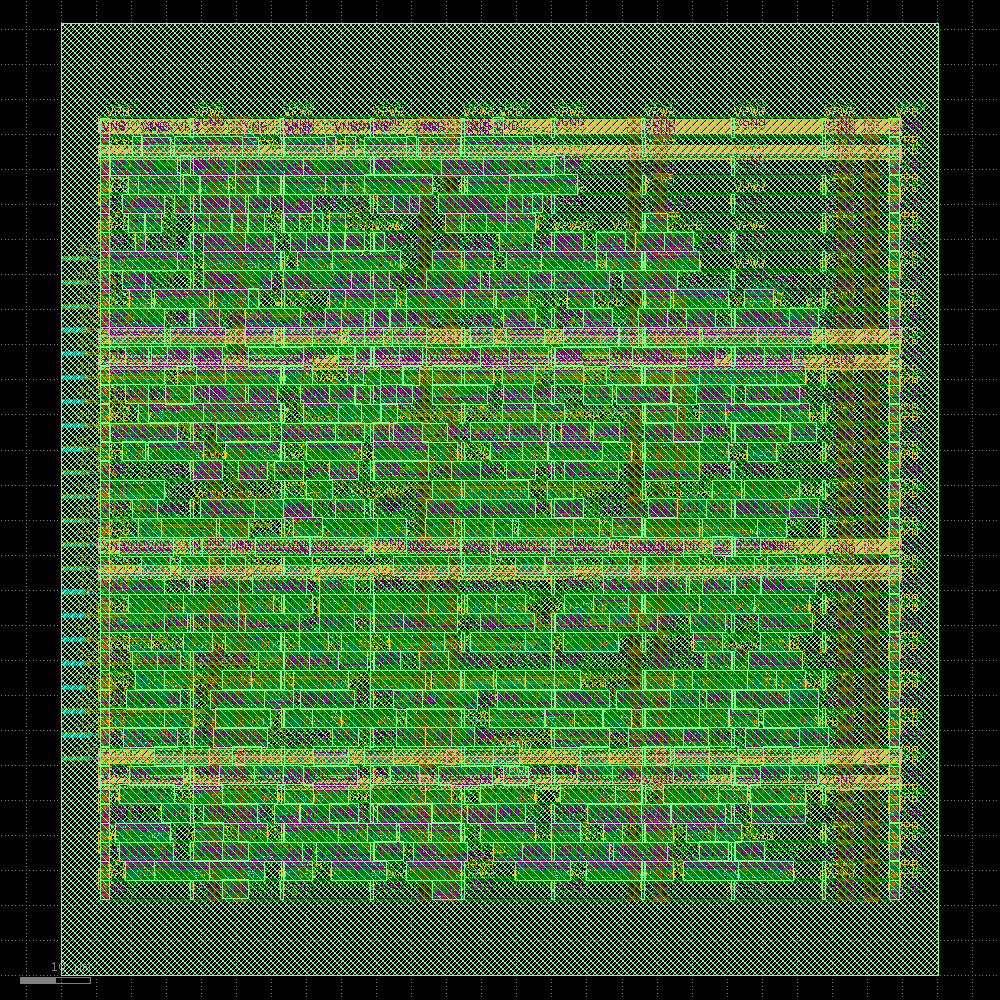

In [78]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [79]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[21:53:19] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=739775;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=655807;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:53:19] VERBOSE  Logging subprocess to                                                              ]8;id=834145;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=359068;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=592525;file:///content/openlane_run/19-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=746618;file:///content/openlane_run/19-openroad-fillinsertion/openroad-fillinsertion.log\19]8;;\]8;id=592525;file:///content/openlane_run/19-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/18-openroad-detailedrouting/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 707 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/19-openroad-fillinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/19-openroad-fillinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/19-openroad-fillinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/19-openroad-fillinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/19-openroad-fillinsertion/spm.sdc'…

{'nl': Path('/content/openlane_run/19-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/19-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/19-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/19-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/19-openroad-fillinsertion/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 676, 'design__instance__area': Decimal('7170.63'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 125.21 135.93', 'design__core__bbox': '5.52 10.88 119.6 122.4', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 24, 'design__die__area': Decimal('17019.8'), 'design__core__area': Decimal('12722.2'), 'design__instance__count__stdcell': 676, 'design__instance__area__stdcell': Decimal('7170.63'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.563631'), 'design__instance__utilization__stdcell': Decimal('0.563631'), 'floorplan__design__io': 22, 'design__io__hpwl': 1788710, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('263.125'), 'design__instance__displacement__mean': Decimal('0.347'), 'design__instance__displacement__max': Decimal('9.878'), 'route__wirelength__estimated': Decimal('11657.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 502, 'route__net__special': 2, 'route__drc_errors__iter:1': 513, 'route__wirelength__iter:1': 15661, 'route__drc_errors__iter:2': 136, 'route__wirelength__iter:2': 15472, 'route__drc_errors__iter:3': 94, 'route__wirelength__iter:3': 15302, 'route__drc_errors__iter:4': 1, 'route__wirelength__iter:4': 15293, 'route__drc_errors__iter:5': 0, 'route__wirelength__iter:5': 15289, 'route__drc_errors': 0, 'route__wirelength': 15289, 'route__vias': 3956, 'route__vias__singlecut': 3956, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[21:53:32] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=168364;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=923031;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[21:53:32] VERBOSE  Logging subprocess to ]8;id=195415;file:///tmp/openlane_klayout_tmp_mlnhogr7/klayout-render.log\..]8;;\]8;id=576700;file:///tmp/openlane_klayout_tmp_mlnhogr7/klayout-render.log\/tmp/openlane_klayout_tmp_mlnhogr7/]8;;\]8;id=616738;file:///tmp/openlane_klayout_tmp_mlnhogr7/klayout-render.log\klayout-render.log]8;;\…     ]8;id=679282;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=179137;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.13s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
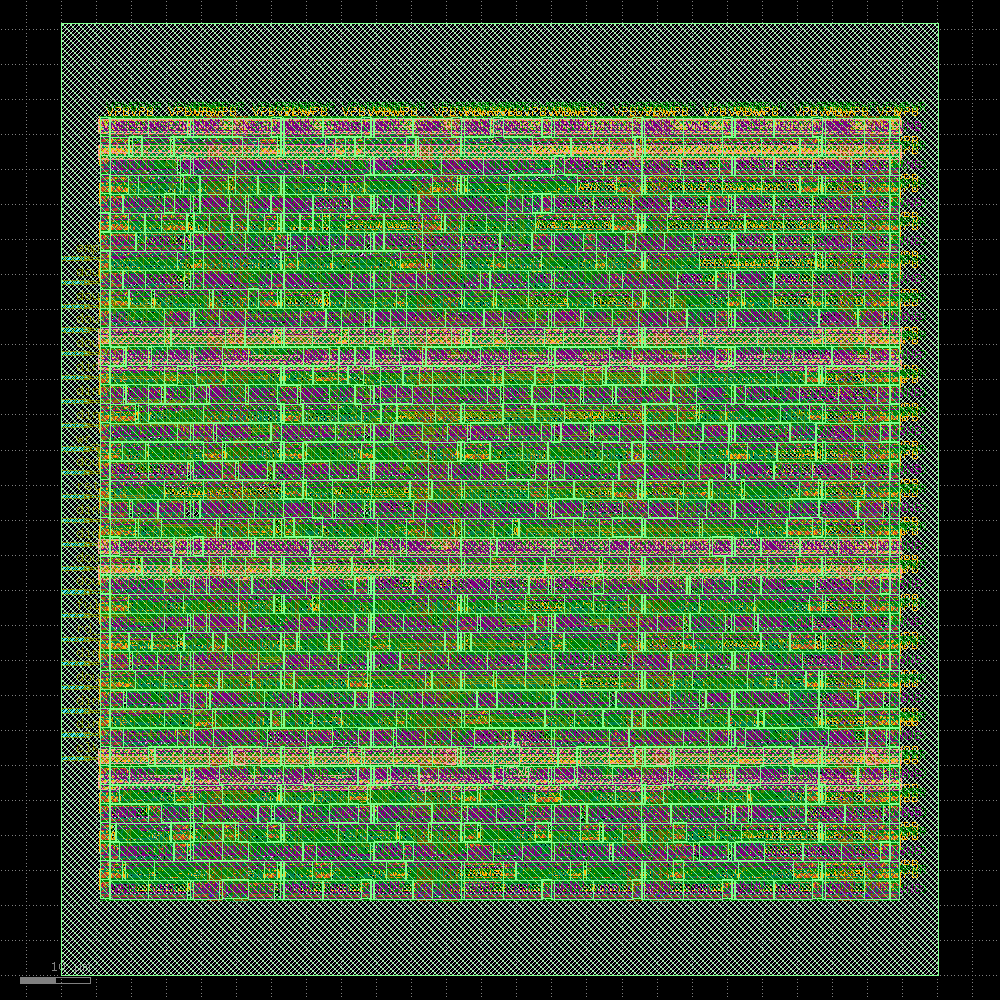

In [80]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [1]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

NameError: name 'Step' is not defined

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [ ]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [ ]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

In [ ]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [ ]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [ ]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [ ]:
LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()